In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import os
from importlib import reload

In [2]:
import dataset_utils
from glob import glob

In [3]:
reload(dataset_utils)

<module 'dataset_utils' from 'c:\\Users\\kzho904\\Documents\\GitHub\\P4P-mmWave\\MMWave_Radar_Human_Tracking_and_Fall_detection\\dataset_utils.py'>

In [4]:
bg_noise_dir = './data/03_09_2024_katie_pc_bg_noise/unique_bg_points.pkl'
with open(bg_noise_dir, 'rb') as file:
        background_data = pickle.load(file)

In [5]:
def background_subtraction(background_data, current_frame_data, threshold=0.1):
    filtered_data = []
    points_removed = []
    num_points_removed = 0
    for point in current_frame_data:
        # print(point)
        distances = np.linalg.norm(background_data[:, :3]- point[:3], axis =1)
        if np.min(distances) > threshold:
            filtered_data.append(point)
        else:
            filtered_data.append([0,0,0,0,0])
            #  filtered_data.append([0,0,0])
            # points_removed.append(point)
    return filtered_data

In [6]:
def parse_dataset(num_points, DATA_DIR):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob(os.path.join(folder, "train/*"))
        test_files = glob(os.path.join(folder, "test/*"))

        all_train_points=[]
        for f in train_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    all_train_points.append(bg_rm_arr)
                concatenated_train_points = np.concatenate(all_train_points, axis=0)
                # concatenated_train_points = background_subtraction(background_data, concatenated_train_points)
                np.random.seed(42)
                sampled_indices = np.random.choice(concatenated_train_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_train_points[sampled_indices].astype(np.float16)
                train_points.append(sampled_data)
                train_labels.append(i)
                # print(data)
                # print("loaded: {}".format(f))
                # print(num_points)
                # sampled_data = data.sample(num_points).to_numpy()
               
        all_test_points = []
        for f in test_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    all_test_points.append(bg_rm_arr)
                
                concatenated_test_points = np.concatenate(all_test_points, axis=0)
                # concatenated_test_points = background_subtraction(background_data, concatenated_test_points)
                np.random.seed(42)
                sampled_indices = np.random.choice(concatenated_test_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_test_points[sampled_indices].astype(np.float16)
                
                test_points.append(sampled_data)
                test_labels.append(i)
                # print(data)
                # print("loaded: {}".format(f))
                # print(num_points)
                # sampled_data = data.sample(num_points).to_numpy()
                # print(test_labels)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [7]:
DATA_DIR = "cluster_data/padded"
NUM_POINTS = 300
NUM_FRAMES = 3
NUM_CLASSES = 4
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS, DATA_DIR)

# Verify the shapes
print(f"train_points shape: {train_points.shape}")
print(f"test_points shape: {test_points.shape}")
print(f"train_labels shape: {np.array(train_labels).shape}")
print(f"test_labels shape: {np.array(test_labels).shape}")

processing class: jumping
processing class: picking_up
processing class: sitting
processing class: walking
train_points shape: (1073, 300, 5)
test_points shape: (269, 300, 5)
train_labels shape: (1073,)
test_labels shape: (269,)


In [8]:
print(CLASS_MAP)

{0: 'padded\\jumping', 1: 'padded\\picking_up', 2: 'padded\\sitting', 3: 'padded\\walking'}


In [9]:
from tensorflow import data as tf_data
import keras
import PointNET

keras.utils.set_random_seed(seed=42)

In [88]:
train_size = 0.8
seed = 42
BATCH_SIZE = 32
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points), seed=seed).map(PointNET.augment)
test_dataset = test_dataset.shuffle(len(test_points), seed=seed).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [79]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer

In [80]:
import tensorflow as tf
from tensorflow import data as tf_data
import keras
from keras import layers
import numpy as np

keras.utils.set_random_seed(seed=42)

def create_pointnet_model(input_shape, num_features, NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)

    # PointNet feature extraction
    x = tnet(inputs, num_features)
    
    # Convolutional layers
    x = conv_bn(x, 64)
    x = conv_bn(x, 64)
    x = conv_bn(x, 128)
    x = conv_bn(x, 1024)
    
    # GlobalMaxPooling1D
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Reshape((-1, 1024))(x)
    
    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Flatten()(x)
    # Fully connected layer
    x = layers.Dense(256, activation='relu')(x)
    
    # Final dense layer
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet_lstm")
    return model

# Usage
input_shape = (NUM_POINTS, 5)  # Adjust this based on your input data
num_features = 5  # Features per point (R, v, x, y, SNR, in, if)



In [81]:

model = create_pointnet_model(input_shape, num_features, NUM_CLASSES=4)
model.summary()

Model: "pointnet_lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 300, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 300, 32)   │        192 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 32)   │        128 │ conv1d_21[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 300, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 300, 64)   │      2,112 │ activation_27[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 64)   │        256 │ conv1d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 300, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 300, 512)  │     33,280 │ activation_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 512)  │      2,048 │ conv1d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 300, 512)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_29[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │     32,896 │ activation_30[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_16[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 25)        │      3,225 │ activation_31[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 5, 5)      │          0 │ dense_17[0][0]  

 Total params: 3,112,925 (11.87 MB)

 Trainable params: 3,108,381 (11.86 MB)

 Non-trainable params: 4,544 (17.75 KB)

In [82]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os


In [83]:
INIT_TIMESTAMP = "testing"
checkpoint_dir = os.path.join('model/checkpoints/', INIT_TIMESTAMP)
os.makedirs(checkpoint_dir, exist_ok=True)

In [84]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [41]:
checkpoint_callback = ModelCheckpoint(
    # filepath=os.path.join(checkpoint_dir, 'best.weights.h5'),  # Save weights after each epoch
    save_weights_only=True,  # Save only weights, not the entire model
    save_best_only = True,
    verbose=1  # Print a message when saving
)

TypeError: ModelCheckpoint.__init__() missing 1 required positional argument: 'filepath'

In [89]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks= [ early_stopping_callback]  
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 7.0849 - sparse_categorical_accuracy: 0.6080 - val_loss: 4.5445 - val_sparse_categorical_accuracy: 0.8233
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 4.5127 - sparse_categorical_accuracy: 0.8337 - val_loss: 4.1882 - val_sparse_categorical_accuracy: 0.8744
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 4.4403 - sparse_categorical_accuracy: 0.8413 - val_loss: 4.1555 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 4.2605 - sparse_categorical_accuracy: 0.9611 - val_loss: 4.0103 - val_sparse_categorical_accuracy: 0.9721
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 4.1457 - sparse_categorical_accuracy: 0.9953 - val_loss: 3.9072 - val_sparse_categorical_accuracy: 1.0000


In [43]:
from matplotlib import pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
[[[-1.640e+00  1.227e+00  2.822e-01 -6.260e-01  2.020e+02]
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
  ...
  [ 7.598e-01  2.857e+00  1.836e-01 -5.010e-01  2.110e+02]
  [ 1.091e+00  2.113e+00  7.715e-01  5.010e-01  2.280e+02]
  [-1.544e+00  1.994e+00  1.407e+00  8.765e-01  1.920e+02]]

 [[-1.640e+00  1.227e+00  2.822e-01 -6.260e-01  2.020e+02]
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
  ...
  [ 7.051e-01  1.880e+00  4.141e-01 -6.260e-01  2.310e+02]
  [-3.855e-01  1.058e+00  1.013e+00  1.252e-01  2.420e+02]
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]]

 [[ 3.467e-02  1.369e+00  6.777e-01  1.252e-01  2.690e+02]
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
  ...
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e

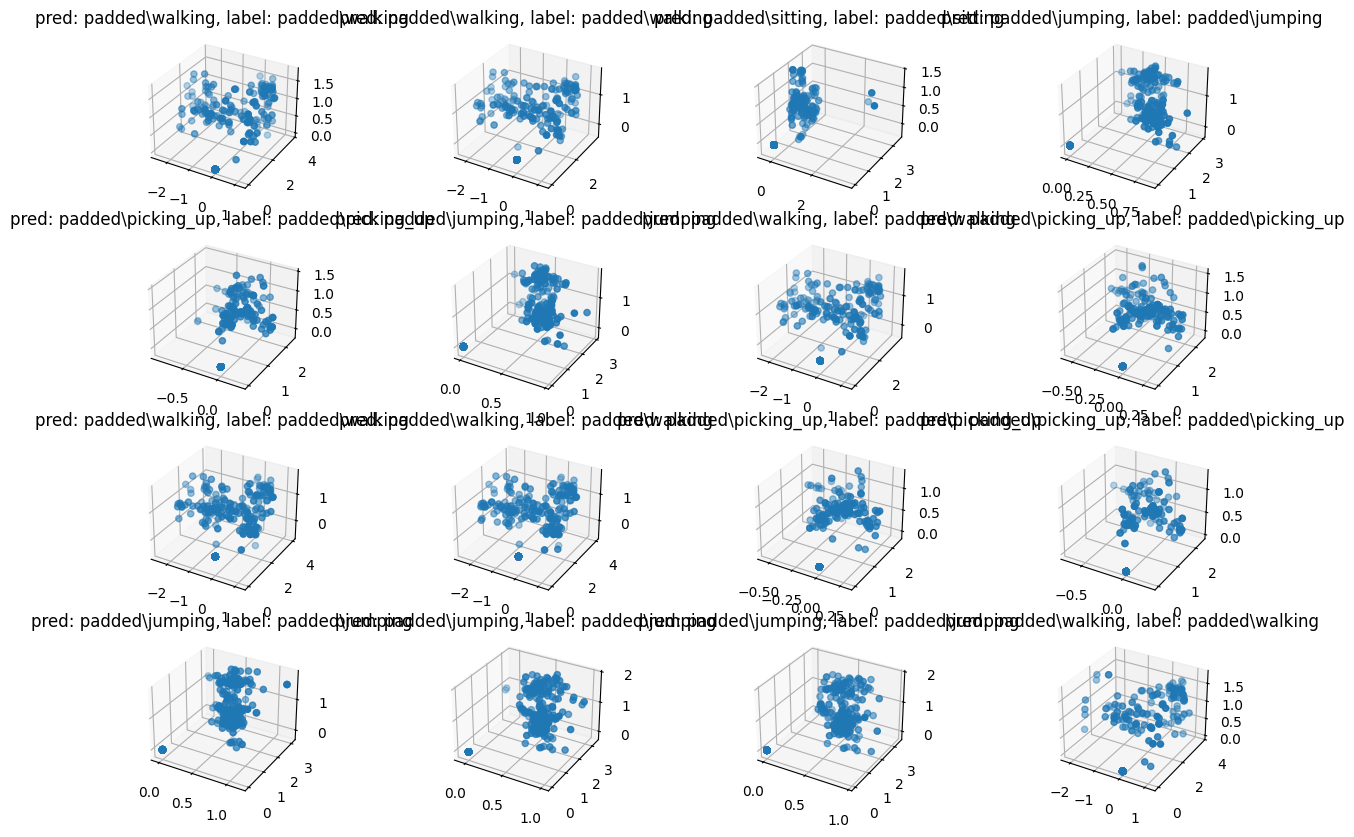

In [44]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
preds = preds.numpy()
labels = labels.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
num_points_to_plot = min(len(points), 16)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i]], CLASS_MAP[labels[i]]
        )
    )
    ax.set_axis_on()
plt.show()

In [66]:
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(test_points) // NUM_POINTS)

for batch in np.array_split(test_points, num_sections): 
    preds = model.predict(batch)
    print("pred is", preds)
    print(batch.shape)
    preds = np.argmax(preds, axis=-1)
    print("argmax is", preds)
    predictions.extend(preds)

predictions = np.array(predictions)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
pred is [[9.9894696e-01 2.1377896e-04 8.0889848e-04 3.0362145e-05]
 [9.9943286e-01 9.9488330e-05 4.1307494e-04 5.4568940e-05]
 [9.9946445e-01 1.0892988e-04 4.0079810e-04 2.5812609e-05]
 ...
 [5.2119914e-05 5.8059195e-05 1.3502888e-04 9.9975485e-01]
 [5.2119914e-05 5.8059195e-05 1.3502888e-04 9.9975485e-01]
 [4.7061883e-05 5.7385540e-05 1.2991935e-04 9.9976569e-01]]
(269, 300, 5)
argmax is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3]


In [136]:
predictions = []
true_labels = []

# Iterate over the test_dataset to make predictions
for batch, labels in test_dataset:
    for sample, label in zip(batch, labels):
        sample = np.expand_dims(sample, axis=0)  # Add batch dimension
        preds = model.predict(sample)  # Make a prediction
        preds = np.argmax(preds, axis=-1)  # Get the class with the highest probability
        
        predictions.extend(preds)  # Extend the predictions list
        true_labels.extend([label.numpy()])  # Append the true label (not extend)

# Convert to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[3]
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[0]
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[3]
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[0]
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[3]
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[2]
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[2]
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[0]
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[2]
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[0]
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[0]
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[3]
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[2]
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[3]
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[0]
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[2]
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[3]
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[3]
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[2]
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
[3]
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[2]
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[3]
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [129]:
print(len(predictions))

269


In [130]:
print(len(true_label))

0


In [112]:
print(test_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 300, 5), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [124]:
accuracy = np.sum(predictions == true_label) / len(true_label)
print(f"Accuracy: {accuracy * 100:.2f}%")

ValueError: operands could not be broadcast together with shapes (269,) (0,) 

In [118]:
print(predictions)

[0 2 2 3 3 0 3 2 3 3 2 2 3 2 3 3 3 2 3 3 2 0 3 2 2 3 3 2 0 3 3 2 3 2 3 2 0
 3 2 2 0 3 3 3 3 0 0 2 2 3 2 2 2 3 3 0 2 2 0 0 2 2 2 0 3 2 3 2 2 3 3 0 0 3
 2 2 3 2 2 2 3 3 3 0 3 2 3 3 3 3 3 3 3 3 3 3 2 0 3 3 0 2 0 3 3 2 0 2 3 0 2
 3 3 0 3 3 3 3 0 0 0 0 3 3 2 3 2 2 2 3 2 0 0 0 3 3 2 0 0 2 3 0 3 0 0 2 0 3
 0 3 3 3 2 3 3 3 0 2 0 2 0 2 2 3 3 3 3 0 3 0 3 0 3 2 3 3 2 0 0 2 2 3 2 2 3
 3 3 2 3 3 2 3 0 0 3 2 3 0 0 2 2 2 3 3 3 0 0 2 2 3 2 3 3 3 0 3 3 2 2 0 0 3
 3 3 0 0 0 3 2 3 2 3 3 0 0 3 3 2 3 2 3 3 0 3 2 2 3 3 2 3 3 3 3 2 3 3 2 3 3
 3 0 3 3 3 0 3 2 0 0]


In [119]:
print(true_label)

[0 0 0 3 3 0 3 1 3 3 1 2 3 1 3 3 3 2 3 3 1 0 3 1 1 3 3 2 0 3 3 2 0 1 3 0 0
 3 0 0 0 3 3 3 3 0 0 0 2 3 0 2 2 3 3 0 0 1 0 1 2 1 2 0 3 2 3 1 2 3 3 0 0 0
 1 1 3 1 0 1 3 3 3 0 3 0 3 2 3 3 3 3 3 3 3 3 1 0 3 3 0 2 0 3 3 1 0 2 3 0 1
 3 3 3 3 3 3 3 0 0 0 0 3 3 1 3 2 1 3 3 0 0 1 0 3 3 2 0 0 1 3 0 3 0 0 1 0 3
 1 3 0 3 2 0 3 3 0 1 0 0 1 0 3 3 3 3 3 0 0 0 3 1 0 1 3 3 1 0 1 2 2 3 1 0 3
 3 3 0 3 3 0 3 0 0 3 0 3 0 0 0 2 2 3 3 3 0 0 1 2 3 1 3 3 3 1 3 3 2 2 0 0 3
 3 3 0 0 0 3 1 3 2 0 3 0 0 3 0 2 3 2 3 3 1 3 1 1 3 3 0 3 3 3 3 0 3 0 2 3 3
 3 1 3 3 3 1 3 2 0 0]


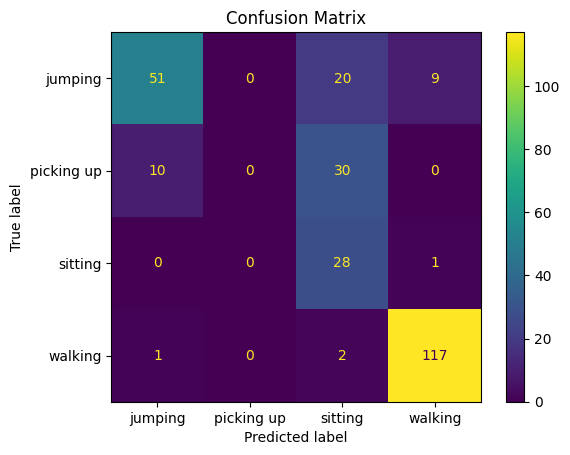

In [120]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plotting the confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(true_label, predictions)

# Plotting the confusion matrix
# class_names = ['walking', 'picking up', 'jumping', 'sitting']  # Based on your CLASS_MAP
class_names = ['jumping','picking up','sitting','walking']
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

# Display the plot
disp.plot()
plt.title("Confusion Matrix")
plt.show()


In [52]:
#reload model
reload_model = create_pointnet_model(input_shape, num_features, NUM_CLASSES=4)
reload_model.load_weights('./model/checkpoints/testing/best.weights.h5')

In [53]:
predictions = []
true_label = []

# Iterate over the test_dataset to make predictions
for batch, label in test_dataset:
    preds = reload_model.predict(batch)  # Get predictions for the current batch
    print("pred is", preds)
    print(batch.shape)
    preds = np.argmax(preds, axis=-1)  # Get the class with the highest probability
    print("argmax is", preds)
    predictions.extend(preds)  # Extend the predictions list with the results
    true_label.extend(label)

true_label = np.array(true_label)
predictions = np.array(predictions)  # Convert predictions to a numpy array


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
pred is [[9.9715960e-01 9.7090477e-04 1.5434929e-03 3.2600516e-04]
 [5.1213522e-03 9.9329716e-01 4.0480122e-04 1.1766712e-03]
 [2.1527309e-04 2.1069740e-04 9.9844331e-01 1.1307376e-03]
 [5.0459218e-01 3.3468020e-03 4.8016986e-01 1.1891212e-02]
 [2.1595135e-04 2.0007389e-04 9.9850959e-01 1.0743797e-03]
 [2.2194690e-04 1.4164788e-04 9.9884880e-01 7.8757538e-04]
 [9.9828076e-01 8.4562058e-04 7.0131297e-04 1.7236146e-04]
 [9.4316196e-01 2.4836843e-03 5.0588544e-02 3.7658520e-03]
 [5.7604402e-01 3.2201072e-03 4.1230494e-01 8.4309578e-03]
 [4.8444518e-03 3.0598964e-04 9.9383509e-01 1.0145128e-03]
 [9.9708825e-01 9.9158194e-04 1.5793680e-03 3.4087521e-04]
 [5.8910274e-04 6.1531919e-03 2.8320465e-03 9.9042565e-01]
 [9.4597989e-01 2.4509898e-03 4.7926418e-02 3.6427167e-03]
 [2.2045013e-03 9.9634027e-01 3.0638525e-04 1.1489255e-03]
 [5.5336136e-01 3.2685706e-03 4.3452299e-01 8.8470578e-03]
 [2.9210612e-01 2.4661629e-03 6.9733787e-01 8.0898507e-03]
 [2.25064

In [72]:
accuracy = np.sum(predictions == true_label) / len(true_label)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 98.51%


In [73]:
print(predictions)

[1 3 3 2 1 3 0 3 3 3 1 2 0 0 0 0 0 3 0 0 3 3 0 3 1 1 3 2 3 1 0 0 0 2 0 3 0
 0 3 0 0 1 0 1 0 3 2 0 1 1 2 3 0 2 3 1 1 3 2 0 3 2 3 0 2 0 3 0 0 2 3 1 3 3
 3 3 1 2 1 3 0 3 3 1 3 0 3 0 3 2 3 0 3 1 0 0 3 3 0 3 0 3 3 3 0 3 3 3 0 3 0
 3 3 3 3 0 3 1 0 2 1 0 3 0 1 1 0 2 0 1 0 3 3 3 3 0 0 3 3 0 3 3 3 3 2 3 0 3
 3 3 1 0 0 3 3 3 0 2 3 1 2 3 0 3 3 3 0 1 0 0 0 0 3 0 0 3 3 3 3 0 2 3 3 3 3
 0 3 1 2 0 2 0 0 0 3 0 3 3 3 3 0 3 2 0 1 1 3 3 0 3 2 1 0 3 3 3 3 0 1 2 1 3
 2 3 3 0 3 3 1 1 1 1 0 1 3 3 0 1 3 0 3 0 0 3 3 3 0 3 0 3 1 2 0 1 2 0 3 3 3
 0 0 3 3 3 0 2 3 2 3]


In [74]:
print(true_label)

[1 3 3 2 1 3 0 3 3 3 1 2 0 0 0 0 0 3 0 0 3 3 0 3 1 1 3 2 3 1 3 0 0 2 0 3 0
 0 3 0 0 1 0 1 0 3 2 0 1 1 2 3 0 2 3 1 1 3 2 0 3 2 3 0 2 0 3 0 0 2 3 1 3 3
 3 3 1 2 1 3 0 3 3 1 3 0 3 0 3 2 3 0 3 1 0 0 3 3 0 3 0 3 3 3 0 3 3 3 0 3 0
 3 3 3 3 0 3 1 0 2 1 0 3 0 1 1 0 2 0 1 0 3 3 3 3 0 0 3 3 0 3 3 3 3 2 3 0 3
 3 3 1 0 0 3 3 3 0 2 3 1 2 3 0 3 3 3 0 1 0 0 0 0 3 0 0 3 3 3 3 0 2 3 3 3 3
 0 3 1 2 0 2 0 0 0 3 0 3 3 3 3 0 3 2 0 1 1 3 3 0 3 2 1 0 3 3 3 3 0 1 2 1 3
 2 3 3 3 3 3 1 1 1 1 0 1 3 3 0 1 3 1 3 0 0 3 3 3 0 3 0 3 1 2 0 1 2 0 3 3 3
 0 3 3 3 3 0 2 3 2 3]


In [62]:
def class_preds(DATA_DIR, model):
    files = glob(os.path.join(DATA_DIR, "[!README]*"))
    predictions = []
    for f in files:
        try:
            with open(f, 'rb') as file:
                
                data = pickle.load(file)
                test_points = []
                sample_test_points = []
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    sample_test_points.append(bg_rm_arr)
                
                data = np.concatenate(sample_test_points, axis=0)
                np.random.seed(42)
                sampled_indices = np.random.choice(data.shape[0], size=300, replace=True)
                sampled_data = data[sampled_indices].astype(np.float16)
                test_points.append(sampled_data)
                # train_labels.append(i)
                # data = np.array(data).reshape(1,300,5)
                test_points = np.array(test_points)
                preds = model.predict(test_points)  # Get predictions for the current batch
                print("pred is", preds)
                print(batch.shape)
                preds = np.argmax(preds, axis=-1)  # Get the class with the highest probability
                print("argmax is", preds)
                predictions.extend(preds)  # Extend the predictions list with the results
        except Exception as e:
            print(f"Error processing file {f}: {e}")

    predictions = np.array(predictions)
    return predictions


In [76]:
# Specify your test directory
test_files = './cluster_data/padded/walking/test'
predictions = class_preds(test_files, reload_model)
# print(len(predictions)) 
accuracy = np.sum(predictions == 0) / len(predictions)
print(accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
pred is [[0.983817   0.00299603 0.01047109 0.00271581]]
(13, 300, 5)
argmax is [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
pred is [[9.9765611e-01 1.6529037e-03 6.0897035e-04 8.2102291e-05]]
(13, 300, 5)
argmax is [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149us/step
pred is [[4.6206336e-03 3.8230012e-04 9.9397063e-01 1.0264349e-03]]
(13, 300, 5)
argmax is [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
pred is [[2.5224817e-04 3.1466622e-04 9.9768150e-01 1.7515197e-03]]
(13, 300, 5)
argmax is [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
pred is [[9.9153239e-01 7.3744813e-03 9.0483204e-04 1.8826549e-04]]
(13, 300, 5)
argmax is [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
pred is [[3.7191520e-04 1.0950565e-04 9.9901164e-01 5.0689880e-04]]
(13, 300, 5)
argmax is [2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
pred is [[5.9526128e-04 6.1584604e-03 3.2630535e-03 9.8998320e-01]]
(13, 300, 5)
argmax is [3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
pred is [[1.0226297e-03 9.9723345e-01 2.666